## PGC Dynamic STAC API Tutorial
### How to query and fetch PGC Digital Elevation Models (DEMs) with python

The [Polar Geospatial Center](https://www.pgc.umn.edu) produces DEMs from high resolution satellite imagery and makes them publicly available for the polar regions through the [ArcticDEM](https://www.pgc.umn.edu/data/arcticdem/) and [Reference Elevation Model of Antarctica (REMA)](https://www.pgc.umn.edu/data/rema/) products, as well as a subset of the [EarthDEM](https://www.pgc.umn.edu/data/earthdem/) data for the area around the Great Lakes region that is publicly available. These are continent-scale, high resolution (2m), repeat coverage elevation models published as time-stamped DEM Strips and (mostly) seamless Mosaics. You can find out more about [this elevation data on our website](https://www.pgc.umn.edu/data/elevation/). 

There are several methods for viewing and downloading the data, but this notebook will focus on how to leverage the dynamic STAC API to query the datasets and retrieve the data you want within a python environment to integrate with geospatial workflows. The data is hosted on the AWS Registry of Open Data ([ArcticDEM](https://registry.opendata.aws/pgc-arcticdem/) and [REMA](https://registry.opendata.aws/pgc-rema/)), where you can browse a static version of the STAC catalog to preview the data or find the link to the dynamic STAC API that we will be demonstrating here. 

### What is STAC?
STAC - [Spatio Temporal Asset Catalog](https://stacspec.org/en) is a standard for organizing geospatial data for convenient access. Essentially, it is a set of GeoJSON-formatted metadata describing location and time for geospatial information, with links to the actual data, organized within sets of Catalogs and Collections. We will look at each of these in turn using python tools to query the API.

### Importing Libraries for STAC API
The first step is to import the necessary pyton libraries for interacting with the API. We will be using the pystac_client library to connect to the PGC STAC Catalog through the API url: `https://stac.pgc.umn.edu/api/v1/`

We will build a query for the STAC API based on geographic location in two ways: frist, by zooming to our area of interest in a webmap within the notebook and second, by defining an area from a shapefile.

Once the API returns the list of DEM items, we will load the metadata into a geopandas dataframe to look at the attributes and finally into an xarray dataset where we can visualize the data and pass it on to any downstream data analysis/processing.

Detailed documentation for the libraries used in this tutorial and additional example workflows can be found at their respective websites:

 - [pystac_client](https://pystac-client.readthedocs.io/en/stable/) - interact with the STAC API
 - [ipyleaflet](https://ipyleaflet.readthedocs.io/en/latest/index.html) - extension of the leaflet mapping library to make interactive web maps within the jupyter notebook for spatial querying
 - [stackstac](https://stackstac.readthedocs.io/en/latest/index.html#) - read STAC API datasets into xarray data structures
 - [xarray](https://docs.xarray.dev/en/stable/) - work with multidimensional arrays, lazy loading, and parallel processing - great for geospatial raster data
 - [geopandas](https://geopandas.org/en/stable/index.html) - read item-level metadata and perform attribute queries on item footprints

In [1]:
# access the STAC API and build a search query
import pystac_client
import ipyleaflet

# read the data for analysis and visualization
import stackstac
import xarray as xr
import geopandas as gpd
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt

# print figures within the jupyter notebook
%matplotlib inline

#### Catalogs

The top level organization of the PGC STAC is the Catalog. This top level contains information about the API itself and the data contained within it, kind of like the top level of a file directory with lots of content organized within. We will load the catalog and take a look at the contents using built in methods from the `pystac_client` library.

Since we are only reading metadata, this data exploration happens almost immediately without having to load any of the actual data.


In [2]:
# access the PGC Data Catalog API
cat = pystac_client.Client.open("https://stac.pgc.umn.edu/api/v1/")
print("Catalog Title: {}".format(cat.title))

# view the components of the Catalog
cat

Catalog Title: PGC Data Catalog


<Client id=pgc-data-stac>

#### Collections

Next, let's look at the collections available within the PGC Catalog. These represent the different products available through the API, broken out by region (ArcticDEM, REMA, and EarthDEM) and product type (DEM Strips and DEM Mosaics) at different resolutions.

In [3]:
# see the available collections in the catalog
for collection in cat.get_collections():
    print(collection)

<CollectionClient id=arcticdem-mosaics-v3.0-2m>
<CollectionClient id=arcticdem-mosaics-v3.0-10m>
<CollectionClient id=arcticdem-mosaics-v3.0-32m>
<CollectionClient id=arcticdem-mosaics-v4.1-2m>
<CollectionClient id=arcticdem-mosaics-v4.1-10m>
<CollectionClient id=arcticdem-mosaics-v4.1-32m>
<CollectionClient id=arcticdem-strips-s2s041-2m>
<CollectionClient id=earthdem-strips-s2s041-2m>
<CollectionClient id=rema-mosaics-v2.0-2m>
<CollectionClient id=rema-mosaics-v2.0-10m>
<CollectionClient id=rema-mosaics-v2.0-32m>
<CollectionClient id=rema-strips-s2s041-2m>


In [4]:
# Filter the collections to view just the REMA datasets
collection_search = cat.collection_search(
    q="rema",
)

for result in collection_search.collections():
    print(result.id, f"{result.description}", sep="\n")
    print("\n")

rema-mosaics-v2.0-2m
REMA DEM mosaics, version 2.0, 2m resolution


rema-mosaics-v2.0-10m
REMA DEM mosaics, version 2.0, 10m resolution


rema-mosaics-v2.0-32m
REMA DEM mosaics, version 2.0, 32m resolution


rema-strips-s2s041-2m
REMA time-stamped strip DEMs, s2s version 4.1, 2m resolution




C:\Users\bakke557\AppData\Local\mambaforge\envs\pgc_plus\Lib\site-packages\pystac_client\collection_search.py:292: UserWarning: Server does not conform to COLLECTION_SEARCH. Filtering will be performed client-side where only bbox, datetime, and q arguments are supported
  warnings.warn(


##### Strip DEMs

Looking at the metadata for the REMA 2m Strip DEMs collection, we can see what data layers are available under `item_assets` and some other information about spatial and temporal extent that get used when querying for specific strips. The `links` information gets called when we want to actually load data from AWS later in the workflow.

Once we start loading actual data, we will want to specify which of the asset layers we want to use. There is, of course, a 2m `DEM` asset with the actual elevation values, but we can also leverage the `mask` to remove any unusable data in the DEM and two 10m `hillshade` layers (one with the mask already applieed) that are useful for quicker/more intuitive visualizations without loading the full resolution `DEM`. 

In [5]:
# get the REMA strips collection
rema_strips_col = cat.get_collection("rema-strips-s2s041-2m")
rema_strips_col

<CollectionClient id=rema-strips-s2s041-2m>

##### DEM Mosaics

Now we can take a look at the metadata in the DEM Mosaics collection. Here we'll look at the 32m REMA Mosaics collection. These data come in tiled rasters covering 100km by 100km areas. When combining them, we arrange them next to each other instead of stacking them like we would with the Strip DEMs. 

You will notice that the `item_assets` are different than the strip DEMs collection. Again we see the `DEM` and `Hillshade` layers, but there is no mask necessary for the mosaics since bad data was removed during the processing, resulting in a mostly seamless elevation surface. Since the mosaics are a combination of data from all the valid DEM strips over an area, each pixel can come from a different source DEM with a different capture date, which gets recorded in the `mindate` and `maxdate` layers for each mosaic tile. 

In [6]:
# get the REMA 32m Mosaics collection metadata
rema_32m_mosaic_col = cat.get_collection("rema-mosaics-v2.0-32m")
rema_32m_mosaic_col

<CollectionClient id=rema-mosaics-v2.0-32m>

#### Items
Finally, we have the items. Each individual data file--in this case a strip DEM or mosaic tile--is represented as a STAC Item. These Items have all the attributes of the DEM files along with links for accessing the data from the cloud directly, as we will show here, or downloading it to use locally. 

To access the items, we will walk through a typical workflow to query one of the Collections (REMA 2m DEM Strips), filtering by location, time, and data quality.

There are multiple ways to create a bounding box to query the collection for data within your Area of Interest (AOI). Here we demonstrate how to use an interactive leaflet map within the notebook to zooom to an area and extract the bounding box coordinate to pass to the API. Zoom/pan the map to the region for which you want the data, then run the code cell below the map to extract the bounding box of the map extent. If you already know the bounding box for your AOI, you can skip the interactive map and update the coordinates in the `bbox` variable with values of latitude and longitude. We'll use the map to identify an AOI within the Ross Island and McMurdo Dry Valleys region.

One note: the default projection for the leaflet map is Web Mercator, which does not work well for areas near the poles, but polar projections are supported, which we will see below.

In [7]:
# create a leaflet map widget to find an AOI for the spatial query of the STAC API
m = ipyleaflet.Map(scroll_wheel_zoom=True)
m.center = -77.5, 164.8
m.zoom = 7
m.layout.height = "600px"
m

Map(center=[-77.5, 164.8], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

In [8]:
# zoom and pan to a location on the map to use for your bounding box
# TIP: running the query at the default zoom level of 7 on the map will return a LOT of records (which is fine since it is only metadata!)
# For a more manageable amount of data for manaul review, we suggest zooming in to a smaller area on the map
bbox = (m.west, m.south, m.east, m.north)
bbox

(165.66009521484378, -78.76297578345728, 168.673095703125, -78.43727203195031)

##### Run the search query for items within your bbox

Now we can perform the actual query to the API to return the Strip DEM items within our bounding box. We will also add a query parameter for `datetime` to restrict the results to a single year. When the items for that query are returned, we can bring them into a geopandas dataframe to ivnestigate further and subset the outputs with more specific attribute queries to the set we want to use for analysis. Since all of this is only working with metadata, we don't have to load any of the actual data yet and the query operations happen immediately. 

In [9]:
# build the API query for the items within out bounding box and date range
search = cat.search(
    collections = ["rema-strips-s2s041-2m"],
    bbox=bbox,
    datetime="2023-01-01/2023-12-31"
)

In [10]:
# fetch the items that fit our search parameters
items = list(search.items())
print(len(items))

8


##### Review item properties with STAC metadata

Let's take a look at a sample strip DEM item that was returned from the query. First, we can see all the associated metadata. By expanding the `properties` section (and printing it all out in the cell below) we can see the individual attributes of the strip DEM. Once we build the geopandas dataframe, we can use those properties to further subset the data based on things like data quality.

In [11]:
items[4]

<Item id=SETSM_s2s041_WV02_20231210_10300100F213AD00_10300100F3A79B00_2m_seg1>

In [12]:
items[4].properties

{'gsd': 2.0,
 'title': 'SETSM_s2s041_WV02_20231210_10300100F213AD00_10300100F3A79B00_2m_seg1',
 'created': '2024-02-18T03:37:15Z',
 'license': 'CC-BY-4.0',
 'pgc:rmse': -9999,
 'proj:code': 'EPSG:3031',
 'published': '2024-06-18T20:08:34Z',
 'pgc:is_lsf': False,
 'proj:shape': [70463, 26308],
 'description': 'Digital surface models from photogrammetric elevation extraction using the SETSM algorithm.  The DEM strips are a time-stamped product suited to time-series analysis.',
 'instruments': ['WV02', 'WV02'],
 'pgc:geocell': 's79e165',
 'end_datetime': '2023-12-10T18:20:49Z',
 'pgc:pairname': 'WV02_20231210_10300100F213AD00_10300100F3A79B00',
 'constellation': 'maxar',
 'pgc:image_ids': ['10300100F213AD00', '10300100F3A79B00'],
 'pgc:is_xtrack': False,
 'proj:geometry': {'type': 'Polygon',
  'coordinates': [[[282664.0, -1299244.0],
    [335280.0, -1299244.0],
    [335280.0, -1158318.0],
    [282664.0, -1158318.0],
    [282664.0, -1299244.0]]]},
 'pgc:stripdemid': 'WV02_20231210_10300100

##### Load items into geopandas dataframe and refine your data query

Now we can load the items returned from the API search into a geopandas dataframe in order to further subset the data to what we want to use. First we will just look at the first five records and explore what the metadata includes. Then we can query out records that have noisy/cloudy data in them and remove corsstrack DEMs (created from "incidental stereo" pairs instead of imagery collected on a single satellite pass). Once we have our final set of data, we can map the footprints to see the data coverage and finally load some data to visualize. 

In [13]:
# load the items into a geopandas dataframe and look at the first five records
items_gdf = gpd.GeoDataFrame.from_features(search.item_collection().to_dict(), crs="epsg:4326").to_crs(3031)
items_gdf.head(5)

,geometry,gsd,title,created,license,pgc:rmse,proj:code,published,pgc:is_lsf,proj:shape,description,instruments,pgc:geocell,end_datetime,pgc:pairname,constellation,pgc:image_ids,pgc:is_xtrack,proj:geometry,pgc:stripdemid,proj:transform,start_datetime,pgc:s2s_version,pgc:avg_sun_elevs,pgc:setsm_version,pgc:cloud_area_sqkm,pgc:valid_area_sqkm,pgc:water_area_sqkm,pgc:cloud_area_percent,pgc:valid_area_percent,pgc:water_area_percent,pgc:avg_convergence_angle,pgc:masked_matchtag_density,pgc:valid_area_matchtag_density,pgc:avg_expected_height_accuracy,datetime
0,"MULTIPOLYGON Z (((253782 -1170390 0, 256588 -1...",2.0,SETSM_s2s041_WV01_20231216_10200100E4C36C00_10...,2024-02-18T03:23:43Z,CC-BY-4.0,-9999,EPSG:3031,2024-06-18T20:08:35Z,False,"[57071, 22022]",Digital surface models from photogrammetric el...,"[WV01, WV01]",s79e168,2023-12-16T16:04:43Z,WV01_20231216_10200100E4C36C00_10200100E6DA0100,maxar,"[10200100E4C36C00, 10200100E6DA0100]",False,"{'type': 'Polygon', 'coordinates': [[[231590.0...",WV01_20231216_10200100E4C36C00_10200100E6DA010...,"[2.0, 0.0, 231590.0, 0.0, -2.0, -1169758.0, 0....",2023-12-16T16:03:54Z,4.1,"[15.666667, 15.638889]",SETSM 4.3.15,457.380152,1998.014092,0.0,0.186276,0.813724,0.0,36.246691,0.788121,0.968535,1.080264,None
1,"MULTIPOLYGON Z (((307010 -1218318 0, 292750 -1...",2.0,SETSM_s2s041_WV02_20231211_10300100F189B400_10...,2024-02-18T03:22:25Z,CC-BY-4.0,-9999,EPSG:3031,2024-06-18T20:08:34Z,False,"[36306, 16942]",Digital surface models from photogrammetric el...,"[WV02, WV02]",s79e165,2023-12-11T19:22:49Z,WV02_20231211_10300100F189B400_10300100F3103100,maxar,"[10300100F189B400, 10300100F3103100]",False,"{'type': 'Polygon', 'coordinates': [[[292558.0...",WV02_20231211_10300100F189B400_10300100F310310...,"[2.0, 0.0, 292558.0, 0.0, -2.0, -1157264.0, 0....",2023-12-11T19:21:44Z,4.1,"[24.1, 24.0]",SETSM 4.3.15,8.049664,1205.528286,0.0,0.006633,0.993367,0.0,30.607040,0.986915,0.993505,1.292014,None
2,"MULTIPOLYGON Z (((253500 -1284298 0, 230234 -1...",2.0,SETSM_s2s041_WV01_20231211_10200100E403E300_10...,2024-02-18T03:19:30Z,CC-BY-4.0,-9999,EPSG:3031,2024-06-18T20:08:35Z,False,"[56861, 21069]",Digital surface models from photogrammetric el...,"[WV01, WV01]",s79e168,2023-12-11T16:18:47Z,WV01_20231211_10200100E403E300_10200100E526BE00,maxar,"[10200100E403E300, 10200100E526BE00]",False,"{'type': 'Polygon', 'coordinates': [[[230210.0...",WV01_20231211_10200100E403E300_10200100E526BE0...,"[2.0, 0.0, 230210.0, 0.0, -2.0, -1171776.0, 0....",2023-12-11T16:17:53Z,4.1,"[16.025, 16.08125]",SETSM 4.3.15,0.000000,2269.753254,0.0,0.000000,1.000000,0.0,41.864629,0.972671,0.972671,0.925198,None
3,"MULTIPOLYGON Z (((299390 -1217564 0, 311966 -1...",2.0,SETSM_s2s041_WV01_20231211_10200100E3BD7800_10...,2024-02-18T03:20:43Z,CC-BY-4.0,-9999,EPSG:3031,2024-06-18T20:08:34Z,False,"[56265, 22646]",Digital surface models from photogrammetric el...,"[WV01, WV01]",s79e166,2023-12-11T00:28:38Z,WV01_20231211_10200100E3BD7800_10200100E592EA00,maxar,"[10200100E3BD7800, 10200100E592EA00]",False,"{'type': 'Polygon', 'coordinates': [[[266676.0...",WV01_20231211_10200100E3BD7800_10200100E592EA0...,"[2.0, 0.0, 266676.0, 0.0, -2.0, -1163962.0, 0....",2023-12-11T00:27:47Z,4.1,"[34.4625, 34.43125]",SETSM 4.3.15,34.957968,2216.136684,0.0,0.015529,0.984471,0.0,37.763661,0.973260,0.988612,1.033649,None
4,"MULTIPOLYGON Z (((316430 -1299242 0, 315992 -1...",2.0,SETSM_s2s041_WV02_20231210_10300100F213AD00_10...,2024-02-18T03:37:15Z,CC-BY-4.0,-9999,EPSG:3031,2024-06-18T20:08:34Z,False,"[70463, 26308]",Digital surface models from photogrammetric el...,"[WV02, WV02]",s79e165,2023-12-10T18:20:49Z,WV02_20231210_10300100F213AD00_10300100F3A79B00,maxar,"[10300100F213AD00, 10300100F3A79B00]",False,"{'type': 'Polygon', 'coordinates': [[[282664.0...",WV02_20231210_10300100F213AD00_10300100F3A79B0...,"[2.0, 0.0, 282664.0, 0.0, -2.0, -1158318.0, 0....",2023-12-10T18:19:30Z,4.1,"[21.007692, 20.946154]",SETSM 4.3.15,15.629396,2698.327100,0.0,0.005759,0.994241,0.0,37.668

In [15]:
# query geodataframe based on DEM attributes - we want intrack DEM strips with oevr 80% valid data (eliminate strips with a lot of clouds)
subset_items_gdf = items_gdf[(items_gdf['pgc:is_xtrack'] == False) & (items_gdf['pgc:valid_area_percent'] > 0.8)]

print(len(subset_items_gdf))

7


In [16]:
subset_items_gdf.crs

<Projected CRS: EPSG:3031>
Name: WGS 84 / Antarctic Polar Stereographic
Axis Info [cartesian]:
- E[north]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Antarctica.
- bounds: (-180.0, -90.0, 180.0, -60.0)
Coordinate Operation:
- name: Antarctic Polar Stereographic
- method: Polar Stereographic (variant B)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

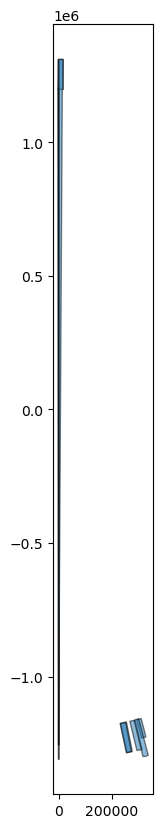

In [17]:
# plot the footprints of the subset geodataframe

# from cartopy import crs as ccrs

x = subset_items_gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor="k")

##### Load data into xarray with StackStac library

Now that we have

In [18]:
%%time

stack = stackstac.stack(items[4], epsg=3031)

stack

CPU times: total: 31.2 ms
Wall time: 17 ms


<xarray.DataArray 'stackstac-4e3d9fcf3e5fbf316132dc071bb308a8' (time: 1,
                                                                band: 5,
                                                                y: 41431,
                                                                x: 16423)> Size: 27GB
dask.array<fetch_raster_window, shape=(1, 5, 41431, 16423), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/42)
  * time                              (time) datetime64[ns] 8B NaT
    id                                (time) <U68 272B 'SETSM_s2s041_WV02_202...
  * band                              (band) <U16 320B 'dem' ... 'hillshade_m...
  * x                                 (x) float64 131kB 2.426e+05 ... 2.766e+05
  * y                                 (y) float64 331kB -1.28e+06 ... -1.363e+06
    description                       <U166 664B 'Digital surface models from...
    ...                                ...
    gsd                               (band) object 40B None None None 10.0 10.0
    instruments                       object 8B {'WV02'}
    proj:geometry                     (band) object 40B None ... {'type': 'Po...
    bands                             (band) object 40B {'unit': 'meter', 'no...
    alternate                         (band) object 40B {'s3': {'href': 's3:/...
    epsg                              int32 4B 3031
Attributes:
    spec:           RasterSpec(epsg=3031, bounds=(242619.5324408508, -1362806...
    crs:            epsg:3031
    transform:      | 2.07, 0.00, 242619.53|\n| 0.00,-2.01,-1279692.08|\n| 0....
    resolution_xy:  (2.0707509276733735, 2.0060951116216708)

MemoryError: Unable to allocate 649. MiB for an array with shape (41431, 16423) and data type bool

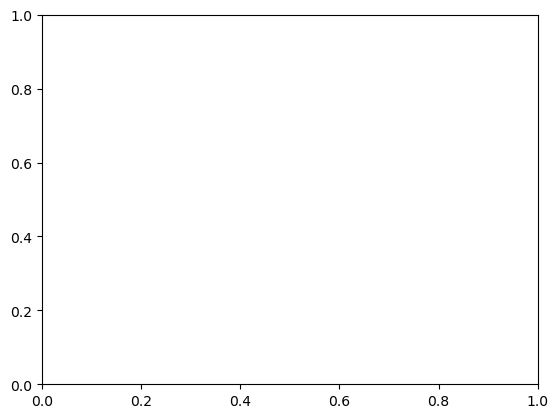

In [19]:
%%time

stack.sel(band='hillshade_masked').plot(cmap='gist_gray')

In [20]:
%%time

stack_all = stackstac.stack(items, epsg=3031)

stack_all

CPU times: total: 62.5 ms
Wall time: 54.4 ms


<xarray.DataArray 'stackstac-2ea8f0e76690f997bde409eaef60fba8' (time: 69,
                                                                band: 5,
                                                                y: 1408569,
                                                                x: 196240)> Size: 763TB
dask.array<fetch_raster_window, shape=(69, 5, 1408569, 196240), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/36)
  * time                              (time) datetime64[ns] 552B NaT NaT ... NaT
    id                                (time) <U68 19kB 'SETSM_s2s041_W1W2_202...
  * band                              (band) <U16 320B 'dem' ... 'hillshade_m...
  * x                                 (x) float64 2MB -1.58e+04 ... 3.772e+05
  * y                                 (y) float64 11MB 1.42e+06 ... -1.397e+06
    gsd                               (band) object 40B None None None 10.0 10.0
    ...                                ...
    pgc:valid_area_matchtag_density   (time) float64 552B 0.8843 ... 0.9884
    pgc:rmse                          int32 4B -9999
    title                             (band) <U20 400B '2m DEM' ... 'Masked 1...
    pgc:geocell                       (time) <U7 2kB 's78e170' ... 's78e169'
    bands                             (band) object 40B {'unit': 'meter', 'no...
    epsg                              int32 4B 3031
Attributes:
    spec:           RasterSpec(epsg=3031, bounds=(-15804.337061718586, -13966...
    crs:            epsg:3031
    transform:      | 2.00, 0.00,-15804.34|\n| 0.00,-2.00, 1420467.28|\n| 0.0...
    resolution_xy:  (2.0028307010161686, 1.9999595612649608)

CPU times: total: 1.67 s
Wall time: 4.07 s


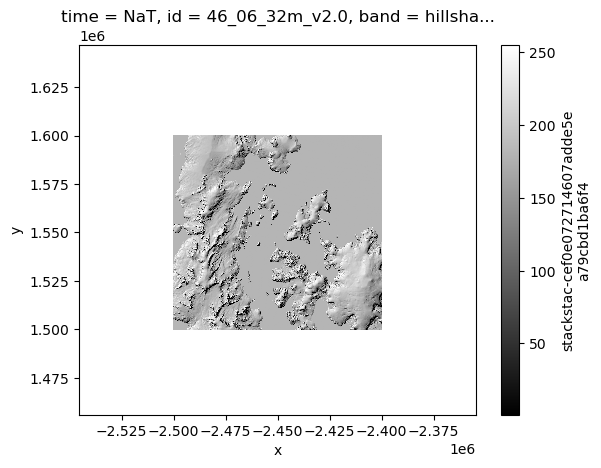

In [77]:
%%time

stack.sel(band='hillshade').plot(cmap='gist_gray')

CPU times: total: 2.08 s
Wall time: 2.71 s


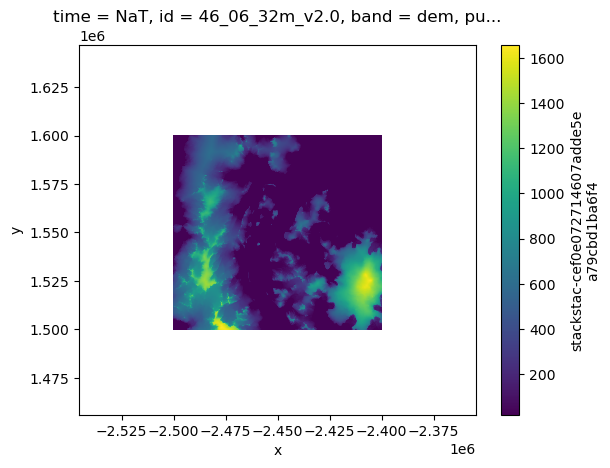

In [67]:
%%time

stack.sel(band='dem').plot()

In [22]:
# note that we need to use the same projection for the layer and the map.
m2 = ipyleaflet.Map(
    center=(-64, -58),
    zoom=8,
    basemap=ipyleaflet.basemaps.Esri.AntarcticBasemap,
    crs=ipyleaflet.projections.EPSG3031.ESRIBasemap,
)

# add draw control on Antarctic map
def handle_draw(target, action, geo_json):
    print(action, geo_json)
    
dc2 = ipyleaflet.DrawControl(marker={"shapeOptions": {"color": "#0000FF"}})
dc2.on_draw(handle_draw)
m2.add(dc2)

# MODIS Mosaic of Antarctica (MOA)
MOA3031 = dict(
    name="EPSG:3031",
    custom=True,
    proj4def="""+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1
        +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs""",
    bounds=[[-3174450, -2816050], [2867175, 2406325]],
)

MOA = ipyleaflet.WMSLayer(
    attribution="""
        U.S. Geological Survey (USGS), British Antarctic Survey (BAS),
        National Aeronautics and Space Administration (NASA)
        """,
    layers="MOA_125_HP1_090_230",
    format="image/png",
    transparent=False,
    opacity=0.5,
    url="https://nimbus.cr.usgs.gov/arcgis/services/Antarctica/USGS_EROS_Antarctica_Reference/MapServer/WmsServer",
    crs=MOA3031,
)
# m2.add(MOA)

m2.add(stack.sel(band='hillshade').isel(time=0))

m2

NameError: name 'stack' is not defined

In [93]:
stack.sel(band='hillshade').isel(time=0)

<xarray.DataArray 'stackstac-cef0e072714607adde5ea79cbd1ba6f4' (y: 3132, x: 3132)> Size: 78MB
dask.array<getitem, shape=(3132, 3132), dtype=float64, chunksize=(1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/26)
    time                 datetime64[ns] 8B NaT
    id                   <U14 56B '46_06_32m_v2.0'
    band                 <U14 56B 'hillshade'
  * x                    (x) float64 25kB -2.545e+06 -2.545e+06 ... -2.355e+06
  * y                    (y) float64 25kB 1.647e+06 1.647e+06 ... 1.456e+06
    published            <U20 80B '2022-08-24T20:14:42Z'
    ...                   ...
    pgc:release_version  <U3 12B '2.0'
    constellation        <U5 20B 'maxar'
    pgc:tile             <U5 20B '46_06'
    alternate            object 8B {'s3': {'href': 's3://pgc-opendata-dems/re...
    bands                object 8B {'unit': 'meter', 'nodata': 0, 'data_type'...
    epsg                 int32 4B 3031
Attributes:
    spec:           RasterSpec(epsg=3031, bounds=(-2545420.207433613, 1455919...
    crs:            epsg:3031
    transform:      | 60.90, 0.00,-2545420.21|\n| 0.00,-60.90, 1646663.85|\n|...
    resolution_xy:  (60.90104812502663, 60.90183625278158)

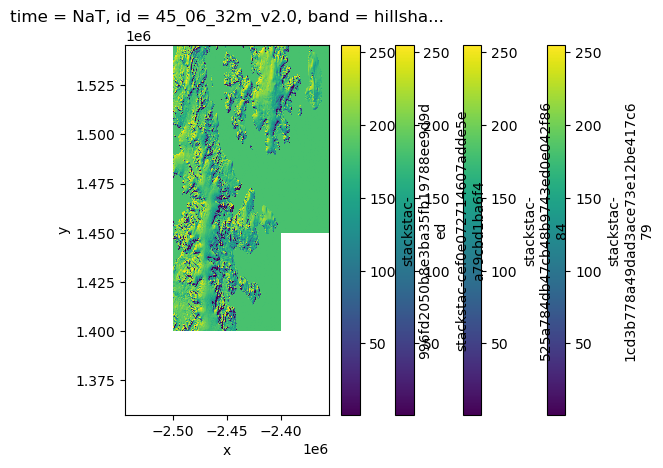

In [50]:
for i in range(len(items)):
    stack = stackstac.stack(items[i], epsg=3031)
    stack.sel(band='hillshade').plot()